In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [154]:
df = pd.read_csv('data.tsv', sep='\t', names=['timestamp', 'transport_id', 'transport_type', 'route_id', 'lat', 'lon'],
                parse_dates=[0], dtype={'transport_id': 'category', 'type': 'category', 'route_id': 'category'})
target_stops = pd.read_csv('debug.tsv', sep='\t', names=['transport_type', 'route_id', 'lat', 'lon'],
                           dtype={'id': 'category', 'type': 'category', 'route_id': 'category'})

In [152]:
df.head()

,timestamp,transport_id,transport_type,route_id,lat,lon
0,2015-05-12 14:24:33,3982,tramway,1,50.700576,51.212909
1,2015-05-12 14:25:13,3982,tramway,1,50.702068,51.212772
2,2015-05-12 14:25:53,3982,tramway,1,50.702930,51.212703
3,2015-05-12 14:26:33,3982,tramway,1,50.705974,51.212421
4,2015-05-12 14:27:13,3982,tramway,1,50.706775,51.212428


In [155]:
df.describe()

,lat,lon
count,1.064095e+06,1.064095e+06
mean,5.060662e+01,5.110628e+01
std,8.465822e-02,1.437978e-01
min,5.029642e+01,5.014520e+01
25%,5.054471e+01,5.105372e+01
50%,5.061157e+01,5.112848e+01
75%,5.067606e+01,5.118990e+01
max,5.104615e+01,5.205867e+01


In [182]:
# route_id = '11'
# transport_id = '7299'
# transport_type = 'tramway'

# route_id = '86'
# transport_id = '7090'
# transport_type = 'bus'

route_id = '71'
transport_id = '2991'
transport_type = 'trolleybus'

In [183]:
debug_route = df[  (df['transport_type'] == transport_type) 
               & (df['route_id'] == route_id)
               & (df['transport_id'] == transport_id)]

In [185]:
debug_route = debug_route.sort_values('timestamp')

In [186]:
debug_route.head()

,timestamp,transport_id,transport_type,route_id,lat,lon
503762,2015-05-12 18:24:41,2991,trolleybus,71,50.556419,51.059322
503763,2015-05-12 18:26:01,2991,trolleybus,71,50.556656,51.057040
503764,2015-05-12 18:28:42,2991,trolleybus,71,50.559059,51.046548
503765,2015-05-12 18:30:02,2991,trolleybus,71,50.560135,51.042094
503766,2015-05-12 18:32:41,2991,trolleybus,71,50.558399,51.039382


In [187]:
time_deltas = debug_route['timestamp'] - debug_route['timestamp'].shift()

In [188]:
time_deltas.describe()

count                       110
mean     0 days 00:01:49.700000
std      0 days 00:01:19.804411
min             0 days 00:01:19
25%             0 days 00:01:20
50%             0 days 00:01:20
75%             0 days 00:01:40
max             0 days 00:12:20
Name: timestamp, dtype: object

Get route reset steps

In [203]:
split_delta = time_deltas.quantile(0.95)
print('95% timedelta quantile:', split_delta)
route_reset_steps = [0]
for i, delta in enumerate(time_deltas):
    if delta > split_delta:
        print(i)
        route_reset_steps.append(i)

95% timedelta quantile: 0 days 00:04:00
64
100
104


In [198]:
single_travel = debug_route[route_reset_steps[0]:route_reset_steps[1]]

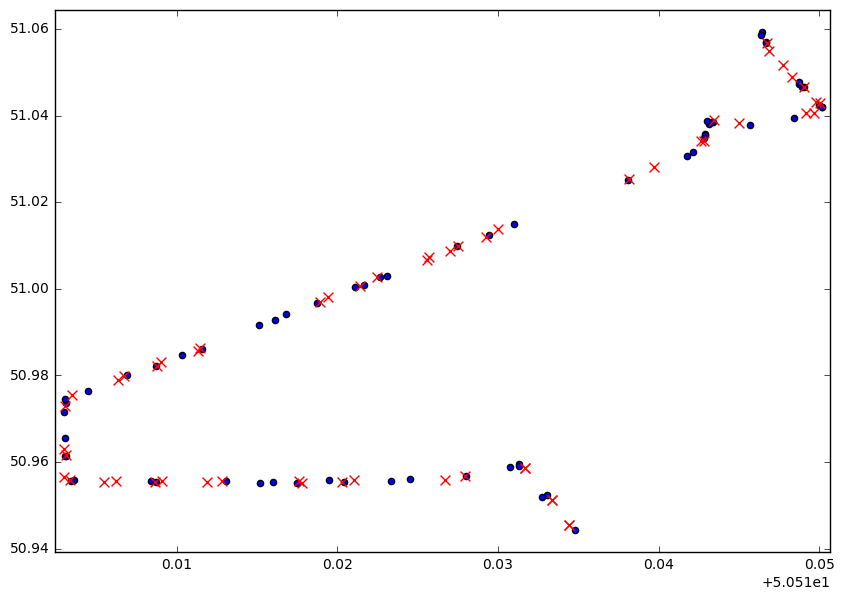

In [200]:
target_bus_stops = target_stops[  (target_stops['transport_type'] == transport_type)
                                & (target_stops['route_id'] == route_id)]

travel_xs = single_travel['lat']
travel_ys = single_travel['lon']

fig = plt.figure(figsize=(10,7))
axes = plt.gca()
axes.set_xlim([0.99999 * min(travel_xs), 1.00001 * max(travel_xs)])
axes.set_ylim([0.9999 * min(travel_ys), 1.0001 * max(travel_ys)])

plt.scatter(travel_xs, travel_ys)
plt.scatter(target_bus_stops['lat'], target_bus_stops['lon'], marker='x', color='red', s=50)
plt.show()